# Здесь подсчитаем насколько плохо/хорошо работает алгоритм LongStaffSchwartz'a сравнивая реальные цены опционов и цены полученные с помощью алгоритма

# TODO: Сделать сравнение европейских опционов раздельно и на битке и на эфире, сначала при 100 траекториях потом при 1000 и сравнить падение, оно должно быть в 5 раз 

In [29]:
import sys
import os
from typing import Tuple, List, Any

notebook_path = os.path.abspath(os.getcwd())
parent_dir = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(parent_dir)

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from hedge.option_schema import OptionSchema
from hedge.implied_volatility import ImpliedVolatility
from lss.algorithm import LongStaffSchwartz
from lss.options import PutOption
from lss.models import NaiveModel
from lss.brownian import BrownianMotionSimulation
from hedge.option_schema import OptionSchema
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")

In [31]:
data = pd.read_csv('../data/server_data/dataset_cleaned.csv', index_col='Unnamed: 0')
data = data.iloc[1:]

data.head()

,dttm,id,price,S,r,S_prev
44343,2023-11-25 08:00:00,BTC-15DEC23-19000-P,3.772141,37721.414063,0.05,37296.316406
44344,2023-11-26 08:00:00,BTC-15DEC23-19000-P,3.779683,37796.828125,0.05,37721.414063
44345,2023-11-27 08:00:00,BTC-15DEC23-19000-P,3.745419,37454.191406,0.05,37796.828125
44346,2023-11-28 08:00:00,BTC-15DEC23-19000-P,3.724799,37247.992188,0.05,37454.191406
44347,2023-11-29 08:00:00,BTC-15DEC23-19000-P,3.782611,37826.105469,0.05,37247.992188


In [58]:
import numpy as np
def count_option_error(data: dict, num_simulations: int):
    try:
        
        if data['price'] == 0:
            return None
        
        # Создаем сущность опциона и считаем волатильность
        option = OptionSchema.model_validate(data)
        iv = ImpliedVolatility(option=option)
        volatility = iv.count()
        
        # Симулируем Монте-Карло пути зная волатильность, процентную ставку, и спот цену сейчас
        brownian = BrownianMotionSimulation(
            S_0=option.spot_price,
            risk_free_rate=option.risk_free_rate*100,
            volatility=volatility*100,
        )
        lss_paths = brownian.simulate(
            num_paths=num_simulations, len_paths=int(option.expiration_time + 1)
        )
        
        # Объявляем опцион и модель для регрессий
        naive_model = NaiveModel(risk_free_rate=option.risk_free_rate*100)
        option_model = PutOption()
        
        # Запускаем алгоритм для подсчета цены 
        lss_model = LongStaffSchwartz(
            risk_free_rate=option.risk_free_rate*100,
            option=option_model,
            strike=option.strike,
            monte_carlo_paths=lss_paths,
            model=naive_model,
        )
        _, _ = lss_model.evaluate(verbose=False)
        
        # Сравниваем цены и сохраняем ошибку
        if option.optionType == "PUT":
            european_lss_price = lss_model._european_option_price()
        else:
            european_lss_price = lss_model._european_option_price() - option.strike*np.exp(-option.risk_free_rate * option.expiration_time/option.expiration_time_denominator) + option.spot_price
        real_european_price = option.option_price
        
        return european_lss_price - real_european_price
    except Exception as e:
        if str(e) == "expected non-empty vector for x":
            return None
        else:
            raise e
        
def count_pricing_error(data: list, num_simulations: int, outliers_border: float) -> tuple[list, list]:
    errors_array = []
    detected_outliers = []
    for el in tqdm(data):
        error = count_option_error(el, num_simulations)
        if error is not None:
            errors_array.append(error)
            if error > outliers_border:
                detected_outliers.append(el)
            
    return errors_array, detected_outliers

In [59]:
eth_sample = data[data.id.str.startswith('ETH')].sample(frac = 1).to_dict('records')[:2000]
btc_sample = data[data.id.str.startswith('BTC')].sample(frac = 1).to_dict('records')[:2000]

ETH - 100 sim

  0%|          | 0/2000 [00:00<?, ?it/s]

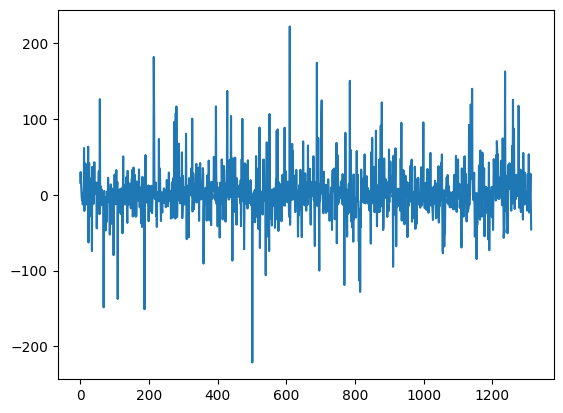

In [60]:
eth_errors_100, eth_outliers_100 = count_pricing_error(eth_sample, 100, 200)

plt.plot([i for i in range(len(eth_errors_100))], eth_errors_100)
plt.show()

ETH - 1000 sim

  0%|          | 0/2000 [00:00<?, ?it/s]

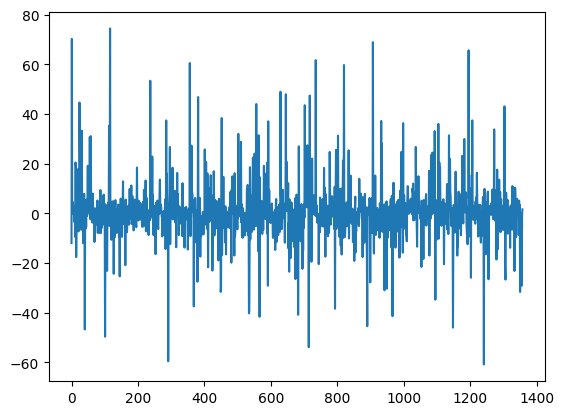

In [61]:
eth_errors_1000, eth_outliers_1000 = count_pricing_error(eth_sample, 1000, 200/np.sqrt(10))

plt.plot([i for i in range(len(eth_errors_1000))], eth_errors_1000)
plt.show()

BTC - 100 sim

  0%|          | 0/2000 [00:00<?, ?it/s]

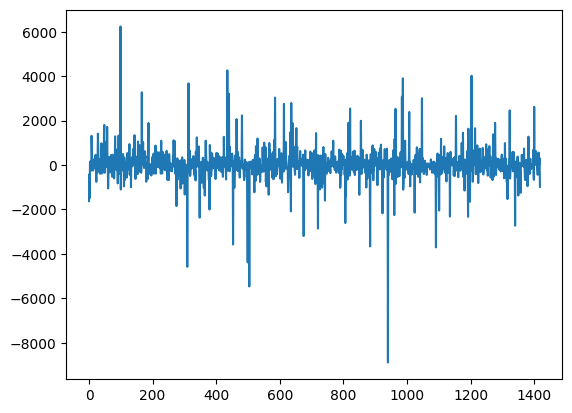

In [62]:
btc_errors_100, btc_outliers_100 = count_pricing_error(btc_sample, 100, 4500)

plt.plot([i for i in range(len(btc_errors_100))], btc_errors_100)
plt.show()

BTC - 1000 sim

  0%|          | 0/2000 [00:00<?, ?it/s]

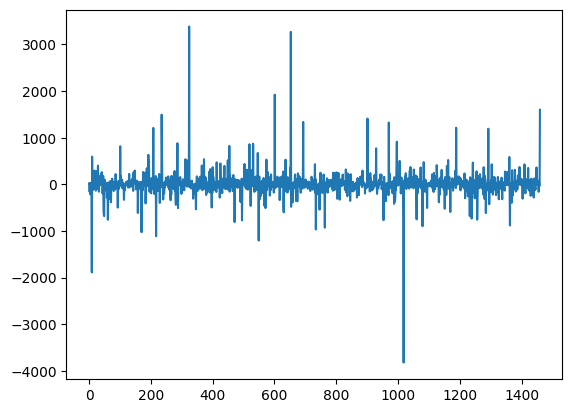

In [63]:
btc_errors_1000, btc_outliers_1000 = count_pricing_error(btc_sample, 1000, 4500/np.sqrt(10))

plt.plot([i for i in range(len(btc_errors_1000))], btc_errors_1000)
plt.show()

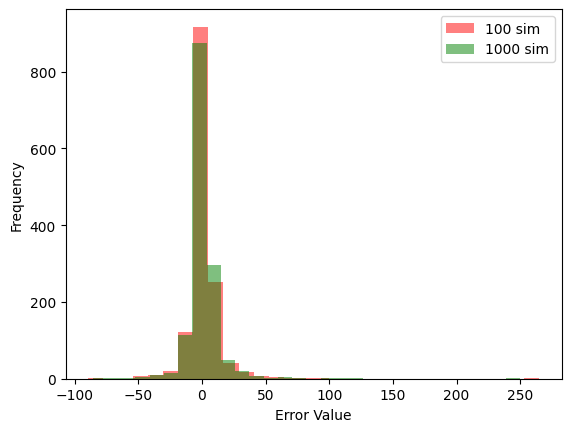

In [55]:
plt.hist(eth_errors_100, bins=30, alpha=0.5, color='red', label='100 sim')
plt.hist(eth_errors_1000, bins=30, alpha=0.5, color='green', label='1000 sim')
plt.xlabel('Error Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

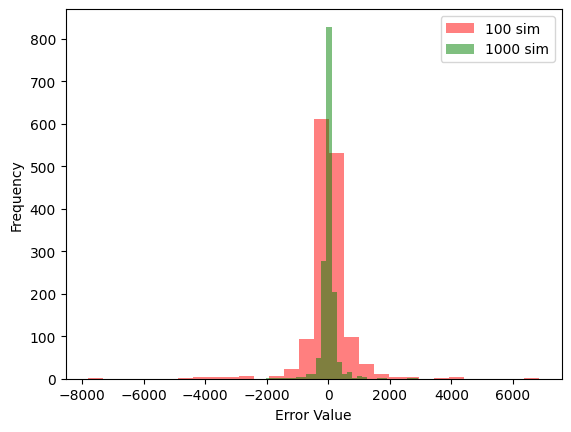

In [56]:
plt.hist(btc_errors_100, bins=30, alpha=0.5, color='red', label='100 sim')
plt.hist(btc_errors_1000, bins=30, alpha=0.5, color='green', label='1000 sim')
plt.xlabel('Error Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [65]:
np.array(eth_errors_100).std(), np.array(eth_errors_1000).std()

(32.35279312630298, 11.635875312686633)

In [66]:
np.array(btc_errors_100).std(), np.array(btc_errors_1000).std()

(726.9721507462359, 272.0037103067096)

In [67]:
btc_outliers_100

[{'dttm': '2024-01-29 08:00:00',
  'id': 'BTC-27DEC24-200000-P',
  'price': 155157.1192635645,
  'S': 42030.914063,
  'r': 0.05,
  'S_prev': 42126.125,
  'base': 'BTC',
  'K': 200000.0,
  'T': 333,
  'T_denominator': 365,
  'optionType': 'PUT'}]

In [68]:
btc_outliers_1000

[{'dttm': '2024-02-11 08:00:00',
  'id': 'BTC-28JUN24-110000-P',
  'price': 70698.07375,
  'S': 47768.96875,
  'r': 0.05,
  'S_prev': 47153.527344,
  'base': 'BTC',
  'K': 110000.0,
  'T': 138,
  'T_denominator': 365,
  'optionType': 'PUT'},
 {'dttm': '2024-02-18 08:00:00',
  'id': 'BTC-23FEB24-80000-P',
  'price': 43964.33540625,
  'S': 51661.96875,
  'r': 0.05,
  'S_prev': 52161.675781,
  'base': 'BTC',
  'K': 80000.0,
  'T': 5,
  'T_denominator': 365,
  'optionType': 'PUT'},
 {'dttm': '2024-02-15 08:00:00',
  'id': 'BTC-23FEB24-80000-P',
  'price': 44113.104167756,
  'S': 51836.785156,
  'r': 0.05,
  'S_prev': 49733.445313,
  'base': 'BTC',
  'K': 80000.0,
  'T': 8,
  'T_denominator': 365,
  'optionType': 'PUT'},
 {'dttm': '2024-02-10 08:00:00',
  'id': 'BTC-27SEP24-160000-P',
  'price': 118355.35363344,
  'S': 47153.527344,
  'r': 0.05,
  'S_prev': 45297.382813,
  'base': 'BTC',
  'K': 160000.0,
  'T': 230,
  'T_denominator': 365,
  'optionType': 'PUT'},
 {'dttm': '2024-01-12 08:00

In [69]:
a = {'dttm': '2024-02-11 08:00:00',
  'id': 'BTC-28JUN24-110000-P',
  'price': 70698.07375,
  'S': 47768.96875,
  'r': 0.05,
  'S_prev': 47153.527344,
  'base': 'BTC',
  'K': 110000.0,
  'T': 138,
  'T_denominator': 365,
  'optionType': 'PUT'}

opt = OptionSchema.model_validate(a)
iv = ImpliedVolatility(option=opt).count()

iv

1.864776611328125